# Nov 17, 2024: Strength of a community
measured as in how many modes does a community occur.  it gives a basic measure to differentiate between the modes; are modes different due to presence/absence of comms.?

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import awkward as ak
from numpy import linalg
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.spatial.distance import cdist
from scipy.spatial.distance import jensenshannon
from multiprocessing import Pool
import glob
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations
from collections import Counter
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'ses'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results_v2/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
parcels_img = ants.image_read(f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{PARC_DESC}_desc-labels.txt')

In [6]:
def get_membership_matrix(args, df):
    num_modes = len(df)
    num_comms = np.max(df['pi'].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0]['pi'].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df[df['mode_id'] == idx_mode]['pi'].to_list()[0]
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

def get_presence_and_strength_of_comms_per_indiv(args, df):
    omegas = df['omega'].to_numpy()
    M = get_membership_matrix(args, df)
    presence = np.any(M > 0.1, axis=0).astype(int) # in which modes does a comm occur
    strength = omegas.T @ presence # total probability of occurrence of a comm.
    return presence, strength

def get_and_save_presence_strength_per_indiv(args, df, level=-1):
    sub = df.iloc[0]['sub']
    presence, strength = get_presence_and_strength_of_comms_per_indiv(args, df)

    out_folder = f'{ESTIM_path}/individual/sub-{sub}/community-presence-strength/{SBM}'
    if level != -1: out_folder = f'{out_folder}/level-{level}'
    os.system(f'mkdir -p {out_folder}')
    np.savetxt(f'{out_folder}/desc-presence.txt', presence, fmt='%.2f')
    np.savetxt(f'{out_folder}/desc-strength.txt', strength, fmt='%.2f')
    return presence, strength

def get_and_save_presence_and_strength(args, indiv_files):
    for indiv_file in tqdm(indiv_files):
        with open(indiv_file, 'rb') as f:
            indiv_marginals_df = pickle.load(f)
        
        indiv_marginals_df['pi'] = indiv_marginals_df['pi'].apply(lambda pi: np.round(pi, decimals=3))
        if args.sbm in ['a', 'd']:
            df = indiv_marginals_df
            presence, strength = get_and_save_presence_strength_per_indiv(args, df, level=-1)
        if args.sbm in ['h']:
            for level in indiv_marginals_df['level'].unique():
                df = indiv_marginals_df[indiv_marginals_df['level'] == level]
                presence, strength = get_and_save_presence_strength_per_indiv(args, df, level=level)
    return None

In [ ]:
def group_level_strong_communities_per_sbm(args, files, level=-1):
    out_folder = f'{ESTIM_path}/group/community-presence-strength/{SBM}'
    if level != -1: out_folder += f'/level-{level}'
    os.system(f'mkdir -p {out_folder}')

    strengths = [
        np.loadtxt(f'{file}/desc-strength.txt') 
        for file in files
    ]
    sdf = pd.DataFrame(strengths)
    sdf = sdf.stack().reset_index()
    sdf.columns = ['sub', 'comm', 'strength']

    med_strengths = sdf.groupby('comm')['strength'].quantile([0.5]).to_numpy()
    strong_comms = np.where(med_strengths > 0.8)[0]
    np.savetxt(f'{out_folder}/desc-important-communities.txt', strong_comms, fmt='%1d')
    # these communities are strongly present across animals, 
    # hence may be important divisions of the brain

    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    ax = axs
    sns.boxplot(sdf, x='comm', y='strength', ax=ax, fill=False)
    sns.stripplot(sdf, x='comm', y='strength', ax=ax, jitter=False)
    xlim = ax.get_xlim()
    ax.axhline(y=0.8, xmin=xlim[0], xmax=xlim[1], c='tab:red', linestyle='--', linewidth=1.5)
    title = f'{SBM}'
    if level != -1: title += f'_level-{level}'
    ax.set(title=title)
    ax.grid(alpha=0.3)
    fig.savefig(f'{out_folder}/desc-important-communities.png')
    
    return strong_comms

def group_level_strong_communities(args, ):
    if args.sbm in ['a', 'd']:
        strengths = []
        out_folders = f'{ESTIM_path}/individual/sub-*/community-presence-strength/{SBM}'
        files = sorted(glob.glob(out_folders))
        _ = group_level_strong_communities_per_sbm(args, files, level=-1)
    if args.sbm in ['h']:
        for level in range(4):
            strengths = []
            out_folders = f'{ESTIM_path}/individual/sub-*/community-presence-strength/{SBM}/level-{level}'
            files = sorted(glob.glob(out_folders))
            _ = group_level_strong_communities_per_sbm(args, files, level=level)
            # break
    return None

In [8]:
sbms_list = [
    (True, 'a'),
    (True, 'd'),
    (True, 'h'),
    (False, 'd'),
    (False, 'h'),
]

sbm--a


100%|██████████| 10/10 [00:00<00:00, 94.42it/s]


sbm-dc-d


100%|██████████| 10/10 [00:00<00:00, 117.71it/s]


sbm-dc-h


100%|██████████| 10/10 [00:00<00:00, 26.13it/s]


sbm-nd-d


100%|██████████| 10/10 [00:00<00:00, 137.66it/s]


sbm-nd-h


100%|██████████| 10/10 [00:00<00:00, 23.21it/s]


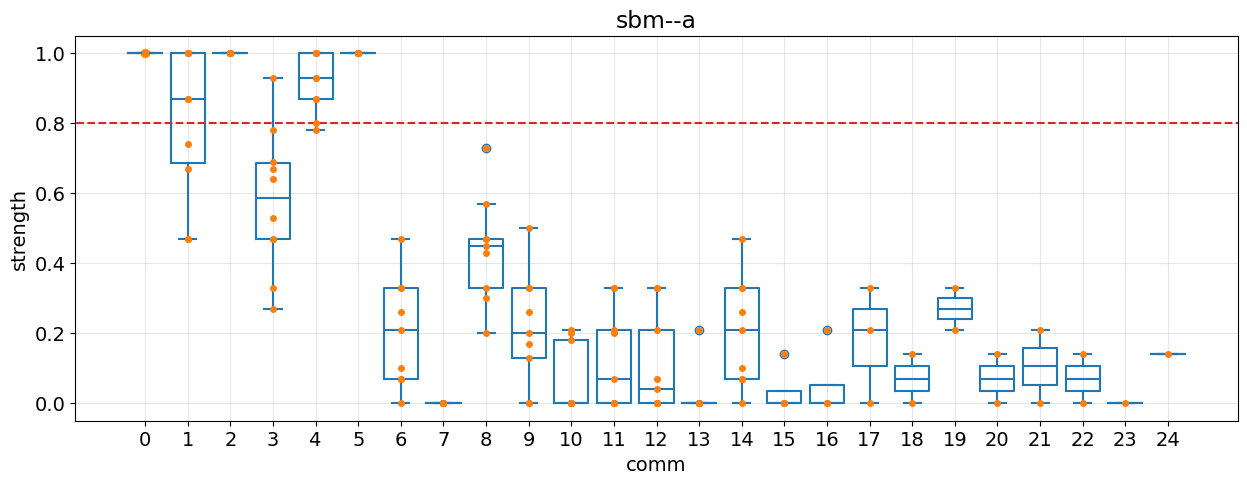

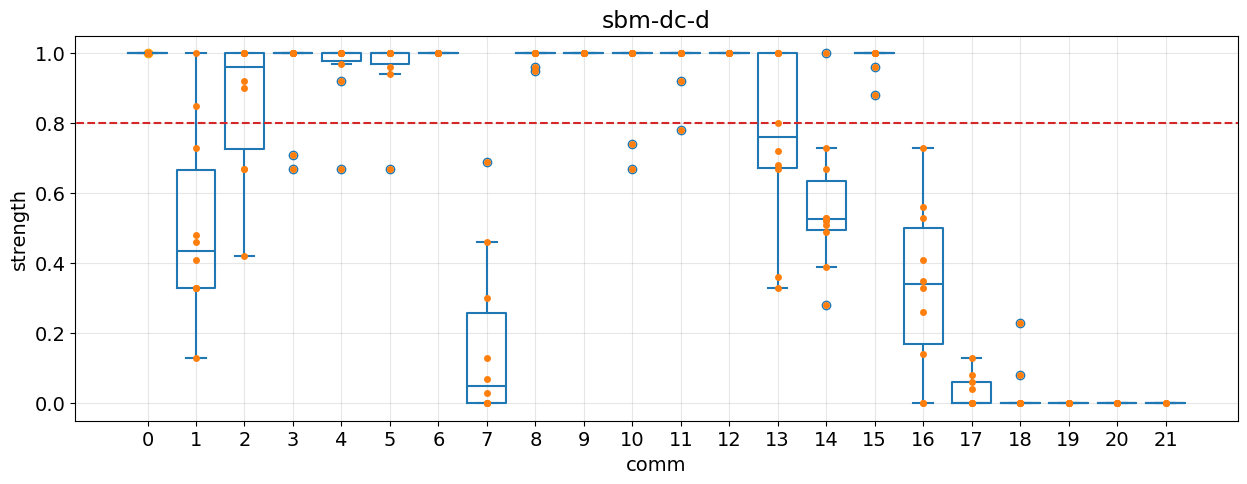

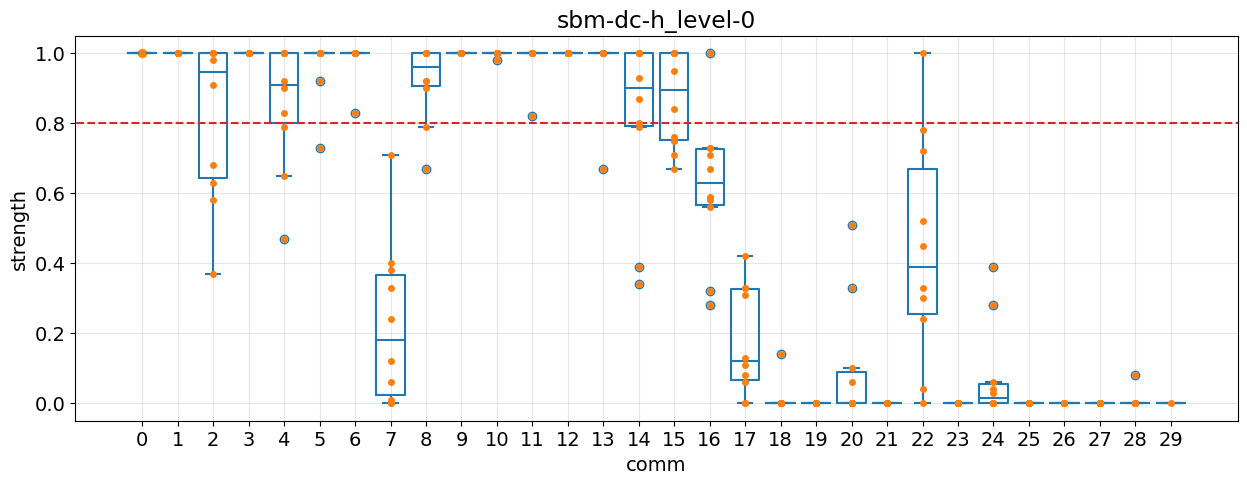

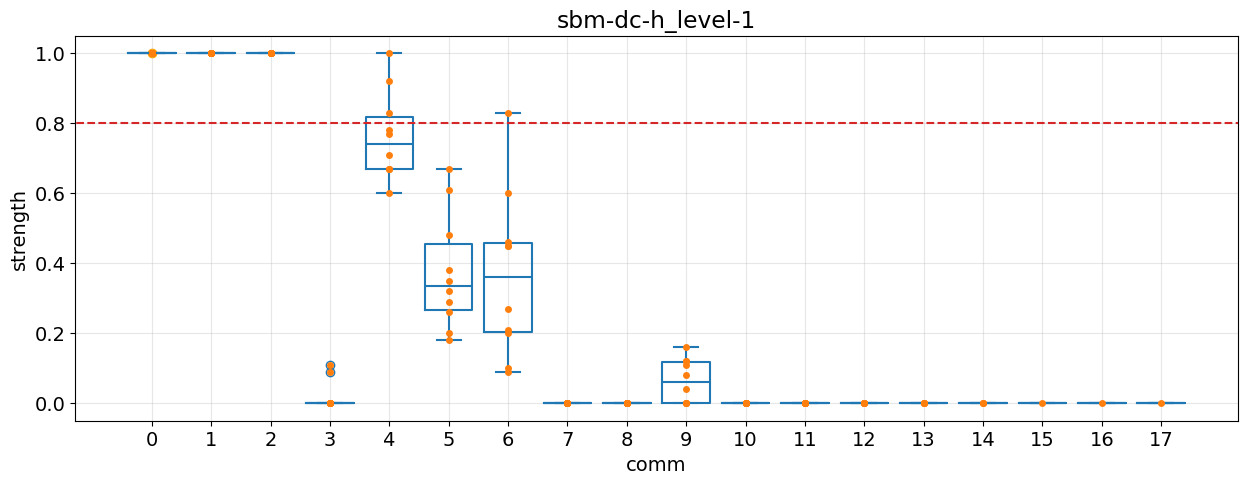

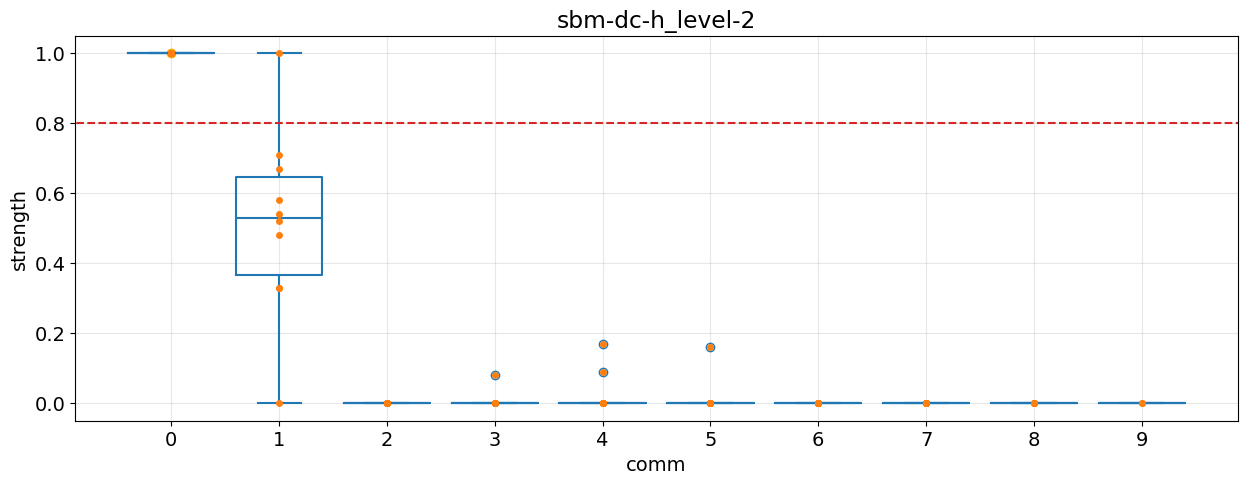

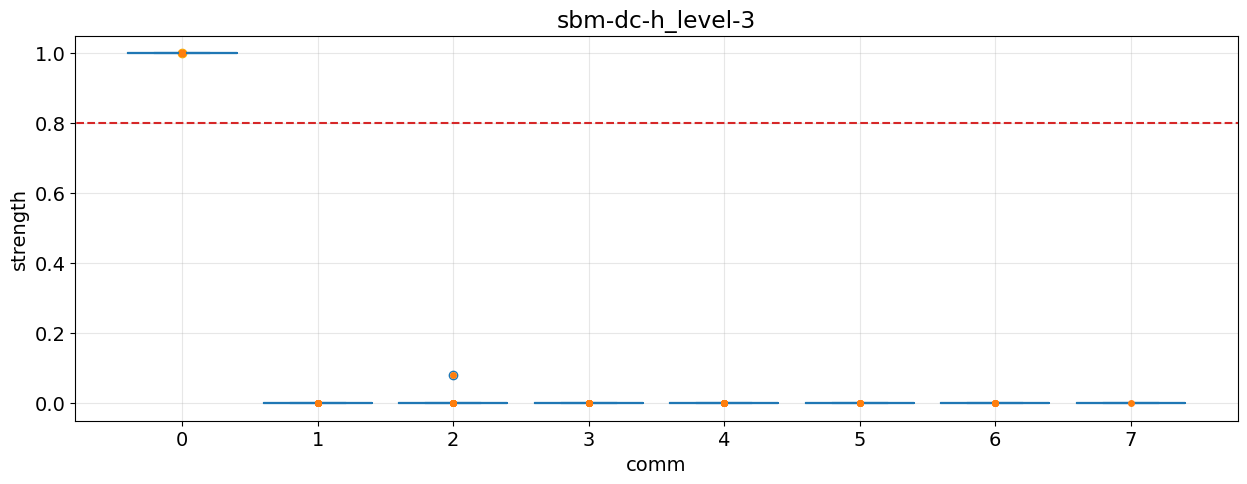

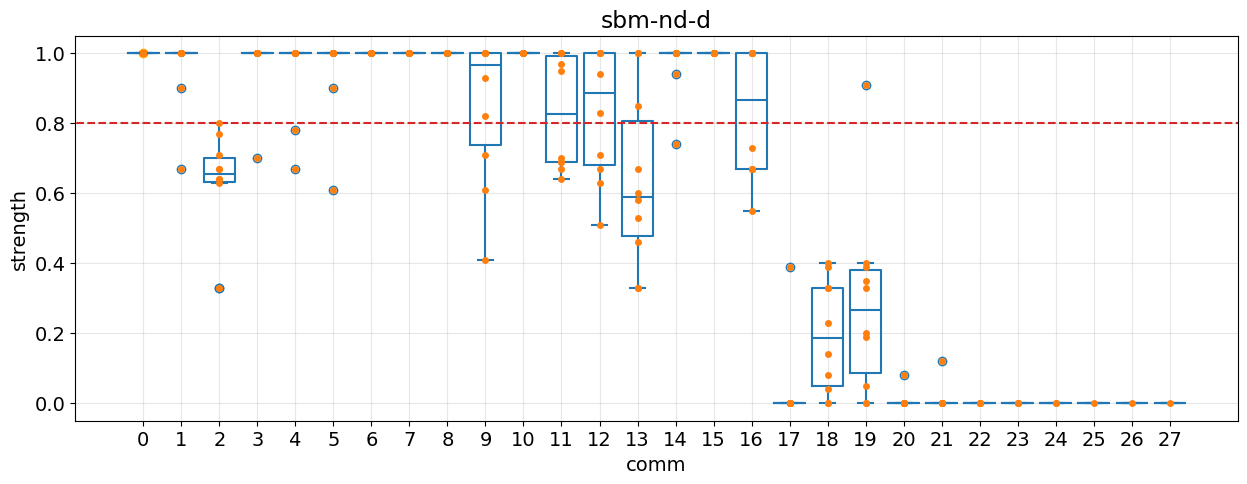

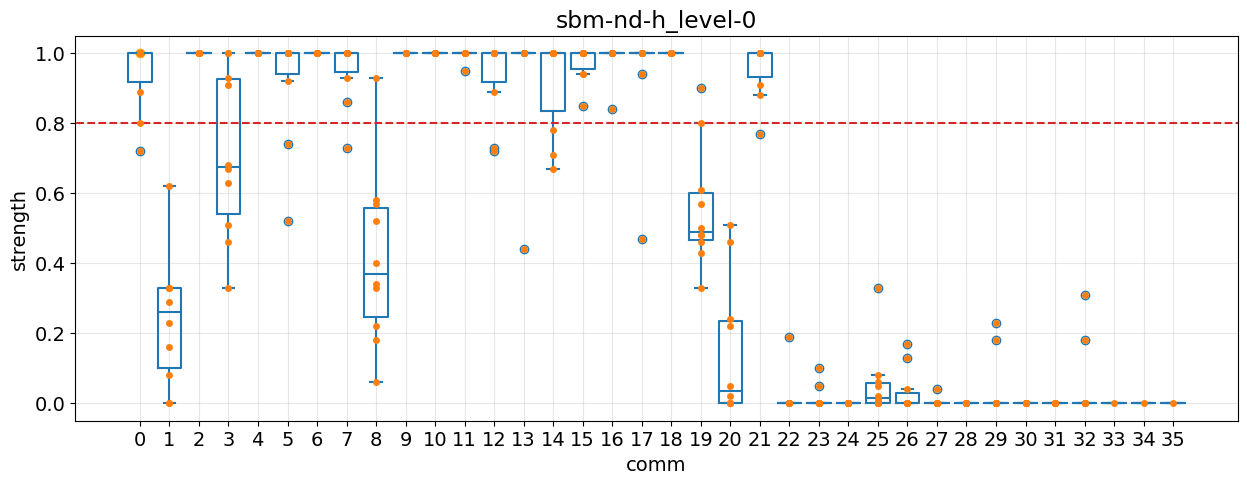

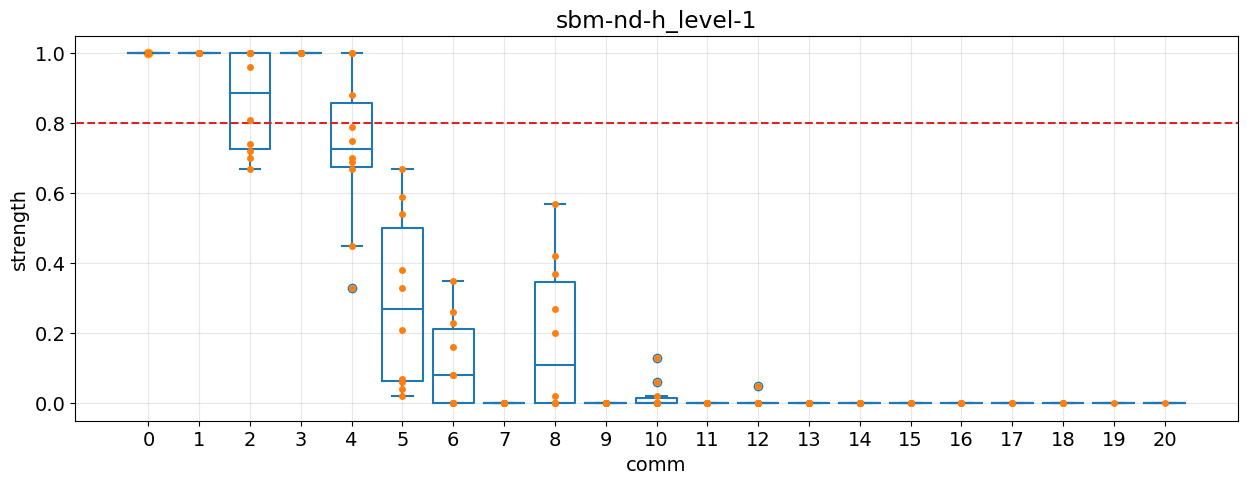

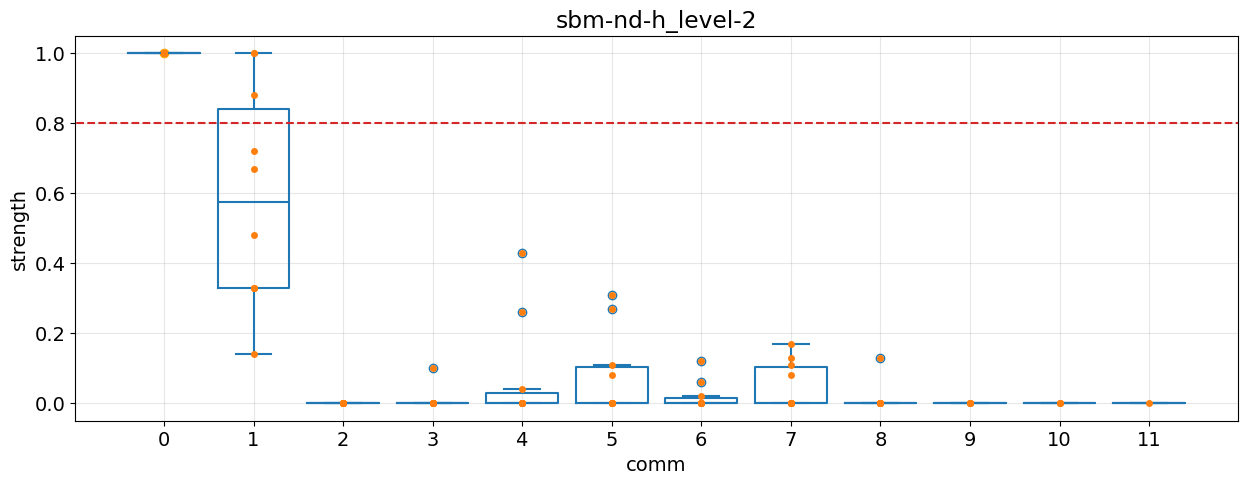

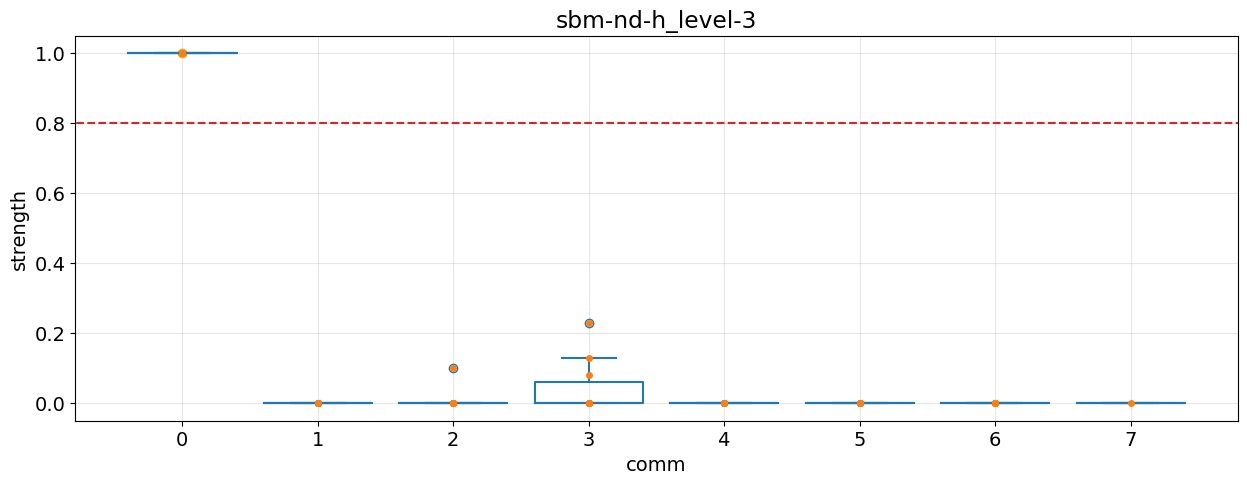

In [9]:
for sbm in sbms_list[:]:
    args.dc, args.sbm = sbm

    args.nested = args.sbm == 'h'

    args.force_niter = 40000
    args.num_draws = int((1/2) * args.force_niter)

    def sbm_name(args):
        dc = f'dc' if args.dc else f'nd'
        dc = f'' if args.sbm in ['a'] else dc
        file = f'sbm-{dc}-{args.sbm}'
        return file

    SBM = sbm_name(args)
    print(SBM)

    indiv_files = sorted(glob.glob(
        f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-marginals-df.pkl', 
        recursive=True
    ))
    # display(indiv_files)
    get_and_save_presence_and_strength(args, indiv_files)
    group_level_strong_communities(args)